# Feature Selection

In [1]:
!pip install xgboost==1.4.0

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot

import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier, plot_importance

## Settings

In [3]:
RAW_DATA_DIR = "./../data/raw"
INTERIM_DATA_DIR = "./../data/interim"
PROCESSED_DATA_DIR = "./../data/processed"
VERSION = "v1.0"
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
matplotlib.rcParams.update(params)

## Load Processed Data

In [4]:
rmoutliers_scaled_df = pd.read_csv(f'{INTERIM_DATA_DIR}/Remove-Outliers-MinMaxScaled-v1.0.csv')

In [5]:
rmoutliers_scaled_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1.0,0.551050,0.436893,0.020408,0.797403,0.587629,0.228070,0.000000,0.428571,0.0,0.10
1,0.0,0.688448,0.388350,0.000000,0.121029,0.167526,0.070175,0.000000,0.000000,0.0,0.05
2,0.0,0.473408,0.368932,0.010204,0.084522,0.196005,0.035088,0.010204,0.000000,0.0,0.00
3,0.0,0.168172,0.291262,0.000000,0.035799,0.212629,0.087719,0.000000,0.000000,0.0,0.00
4,0.0,0.153332,0.718447,0.000000,0.372997,0.225515,0.052632,0.000000,0.071429,0.0,0.05


In [6]:
rmoutliers_scaled_df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [7]:
rmoutliers_scaled_df.isnull().values.any()

False

In [8]:
X = rmoutliers_scaled_df[['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']]
y = rmoutliers_scaled_df['SeriousDlqin2yrs']

## Backward Elimination

In [9]:
# Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const                                    1.102154e-17
RevolvingUtilizationOfUnsecuredLines     0.000000e+00
age                                      9.188158e-16
NumberOfTime30-59DaysPastDueNotWorse    3.880267e-228
DebtRatio                                1.380778e-01
MonthlyIncome                            2.813905e-32
NumberOfOpenCreditLinesAndLoans          2.968550e-10
NumberOfTimes90DaysLate                 1.230670e-191
NumberRealEstateLoansOrLines             6.813906e-01
NumberOfTime60-89DaysPastDueNotWorse     0.000000e+00
NumberOfDependents                       3.607200e-18
dtype: float64

In [10]:
# Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


## Recursive Feature Elimination

In [11]:
X.shape

(107779, 10)

In [12]:
model = XGBClassifier(use_label_encoder=False, verbosity=0, seed=123, random_state=123) #Initializing RFE model
rfe = RFE(model, 10) #Transforming data using RFE
X_rfe = rfe.fit_transform(X,y) #Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


In [13]:
# no of features
nof_list=np.arange(1,10)            
high_score=0

# Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=123)
    model = XGBClassifier(use_label_encoder=False, verbosity=0, seed=123, random_state=123)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 5
Score with 5 features: 0.935563


In [14]:
cols = list(X.columns)
model = XGBClassifier(use_label_encoder=False, verbosity=0, seed=123, random_state=123) #Initializing RFE model
rfe = RFE(model, 5)             #Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  #Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['RevolvingUtilizationOfUnsecuredLines',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'],
      dtype='object')


## Feature Importance

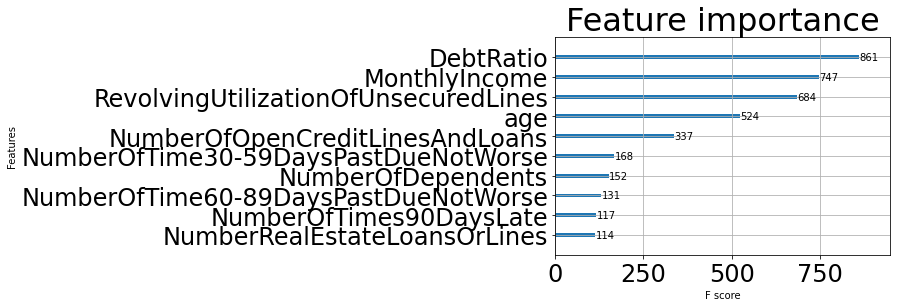

In [15]:
model = XGBClassifier(use_label_encoder=False, verbosity=0, seed=123, random_state=123)
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()